# 2. 폐렴아 기다려라! [프로젝트]

## 프로젝트 : 폐렴 진단기 성능개선

#### 주요 라이브러리 버전 확인

In [1]:
import tensorflow

print(tensorflow.__version__)

2.6.0


## Step 1. 실험환경 Set-up

#### 필요 패키지(라이브러리) import

In [2]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

#### 필요 변수 생성 및 설정

In [3]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [4]:
# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

In [5]:
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

In [6]:
# 프로젝트를 진행할 때 필요한 변수
BATCH_SIZE = 16
EPOCHS = 10

## Step 2. 데이터 준비하기

### 1. 데이터 가져오기

In [7]:
# 데이터 가져오기 및 데이터 개수 확인

In [8]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

In [9]:
print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [10]:
# train 안에는 5216개, test 안에는 624개, val 안에는 16개가 있습니다.
# 개수 비는 89%, 10.7%, 0.3% 입니다.

In [11]:
# val 개수가 너무 없기 때문에 train에서 val에 쓰일 데이터를 가져와서
# train과 val에 있는 데이터를 모은 다음에 train:val를 80:20으로 분할하겠습니다.

### 2. 데이터 전처리 및 배치 구성

#### Train과 validation data를 더해 8:2로 나누기

In [12]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다.
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

In [13]:
# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

In [14]:
print(len(train_filenames))
print(len(val_filenames))

4185
1047


#### Train 데이터 내 정상 이미지 수와 폐렴 이미지 수 확인하기

In [15]:
# 정상 이미지와 폐렴 이미지 구분 (파일 경로에 힌트)

In [16]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


In [17]:
# 파일 경로에 NORMAL과 PNEUMONIA이 있는지 여부로 폐렴 이미지 수 세기

In [18]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


#### tf.data 인스턴스 만들기 (mini-batch 작업하기 위해)

In [19]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [20]:
# train 데이터셋과 validation 데이터셋 개수 확인

In [21]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


#### 라벨 데이터 만들기

In [22]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다

In [23]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

#### 이미지의 사이즈 통일 및 이미지 사이즈 줄이기(GPU 메모리 효율적 사용)

In [24]:
# 이미지를 알맞은 형식으로 바꿉니다. 
# (이미지의 데이터 타입을 float으로 바꾸고, 사이즈를 변경함.)

In [25]:
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

In [26]:
# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.

In [27]:
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

#### Train과 Validation 데이터셋 만들기

In [28]:
# num_parallel_calls 파라미터에 위에서 할당한 AUTOTUNE변수를 이용하면 
# 더욱 빠르게 데이터를 처리해 즐 수 있습니다.

In [29]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [30]:
# 이미지가 잘 리사이즈 되었는지, 그리고 라벨이 잘 들어가 있는지 확인하기

In [31]:
for image, label in train_ds.take(1):  # .take(1)  하나의 데이터만 가져온다는 의미
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [32]:
#### Test 데이터셋 만들기

In [33]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

In [34]:
# 데이터 개수 확인
print(TEST_IMAGE_COUNT)

624


#### 학습 데이터를 효율적으로 사용할 수 있도록 데이터 변환하기 (tf.data 파이프라인 사용)

In [35]:
# shuffle(): 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택함.
# repeat(): epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해줌.
# batch(): 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어짐.
# prefetch():학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있음.

In [36]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

#### Augmentation 도입

In [37]:
# def augment(image,label):
#     image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
#     return image,label

# def prepare_for_training(ds, shuffle_buffer_size=1000):
#     # augment 적용 부분이 배치처리 함수에 추가되었습니다.
#     ds = ds.map(
#             augment,  # augment 함수 적용
#             num_parallel_calls=2
#         )
#     ds = ds.shuffle(buffer_size=shuffle_buffer_size)
#     ds = ds.repeat()
#     ds = ds.batch(BATCH_SIZE)
#     ds = ds.prefetch(buffer_size=AUTOTUNE)

#     return ds

# train_ds = prepare_for_training(train_ds)
# val_ds = prepare_for_training(val_ds)

## Step 3. 데이터 시각화

#### train에 있는 batch 중 첫 번째 배치를 추출하여, image와 label 데이터셋으로 나눔.

In [38]:
image_batch, label_batch = next(iter(train_ds))

#### 결과 사진 확인

In [39]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

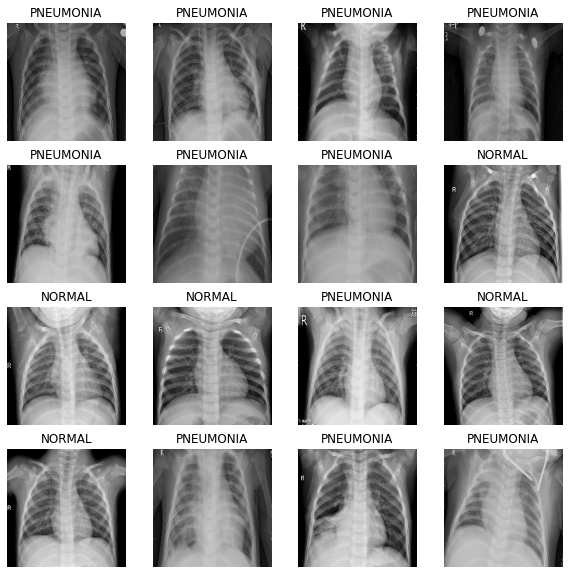

In [40]:
show_batch(image_batch.numpy(), label_batch.numpy())

## Step 4. 모델링(ResNet-18 구현)

#### Convolution block 구성

#### Residual block 구성

In [41]:

def residual_block(inputs, filters, strides=(1, 1), use_conv_shortcut=False):
    shortcut = inputs
    if use_conv_shortcut:
        shortcut = Conv2D(filters, (1, 1), strides=strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Conv2D(filters, (3, 3), strides=strides, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)

    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    return x

#### 모델 생성(ResNet 구현)

## Step 5. 데이터 imbalance 처리

In [43]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

In [44]:
print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


## Step 6. 모델 훈련

#### 성과측정 metrics 생성 및 모델 compile

In [49]:
with tf.device('/GPU:0'):
    model = build_model((180,180,3))

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

#### 모델 fit

In [50]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 120s 223ms/step - loss: 0.6400 - accuracy: 0.8355 - precision: 0.9381 - recall: 0.8339 - val_loss: 84.4516 - val_accuracy: 0.2740 - val_precision: 1.0000 - val_recall: 0.0092
Epoch 2/10
261/261 [==============================] - 58s 221ms/step - loss: 0.3678 - accuracy: 0.8903 - precision: 0.9604 - recall: 0.8894 - val_loss: 0.6026 - val_accuracy: 0.8029 - val_precision: 0.7880 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 57s 219ms/step - loss: 0.2085 - accuracy: 0.9229 - precision: 0.9764 - recall: 0.9186 - val_loss: 0.1448 - val_accuracy: 0.9452 - val_precision: 0.9903 - val_recall: 0.9346
Epoch 4/10
261/261 [==============================] - 58s 224ms/step - loss: 0.2221 - accuracy: 0.9200 - precision: 0.9763 - recall: 0.9147 - val_loss: 1.1438 - val_accuracy: 0.6308 - val_precision: 1.0000 - val_recall: 0.4961
Epoch 5/10
261/261 [==============================] - 59s 225ms/step - loss: 0.1768 - accu

## Step 7. 결과 확인과 시각화

####  훈련과정의 history 그래프 시각화

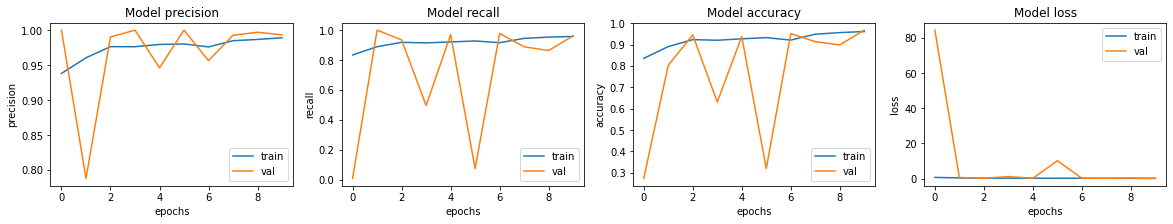

In [51]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

#### Test 데이터로 훈련된 모델 평가하기

In [52]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 130ms/step - loss: 0.6536 - accuracy: 0.8429 - precision: 0.8093 - recall: 0.9795
Loss: 0.6535567045211792,
Accuracy: 0.8429487347602844,
Precision: 0.8093220591545105,
Recall: 0.9794871807098389
